In [1]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu

In [212]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=10, max_count=1000000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [3]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:

exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [16]:
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)



In [5]:
resolution_human = 10000
species = "human"
SRP_name = "aggregates"
resolution = "10kbp_raw"



input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])

In [6]:
    if species == 'human':

        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    else:

        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    df_cre['start_bin'] = df_cre['start']/resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    df_cre['cre'] = 1
    df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')
    
    

In [8]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path

In [10]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none_ranked_inter.h5', 'r') as hf:
    my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]
    

In [282]:
bins_bed

array([     0,      1,      2, ..., 287506, 287507, 287508])

In [134]:
my_percen = np.nanpercentile(my_data, 99, axis=1, keepdims=True)

In [135]:
my_data_thresh = my_data > my_percen

my_data_thresh = my_data_thresh.astype(int)

In [136]:
df_gene_tp = pd.DataFrame(my_data_thresh ,  index=[x.decode() for x in gene_list.tolist()], columns = bins_bed.tolist())


In [45]:
df_gene_tp_all = pd.DataFrame(my_data ,  index=[x.decode() for x in gene_list.tolist()], columns = bins_bed.tolist())


In [46]:
df_gene_tp_all

0         1        2        3        4         5       \
ENSG00000000419  17008.5   55526.0  17008.5  55526.0  55526.0   17008.5   
ENSG00000000457      NaN       NaN      NaN      NaN      NaN       NaN   
ENSG00000000460      NaN       NaN      NaN      NaN      NaN       NaN   
ENSG00000000938      NaN       NaN      NaN      NaN      NaN       NaN   
ENSG00000000971      NaN       NaN      NaN      NaN      NaN       NaN   
...                  ...       ...      ...      ...      ...       ...   
ENSG00000285498  43686.0   43686.0  43686.0  43686.0  43686.0  125641.0   
ENSG00000285505  13750.0  146594.5  44280.0  90535.0  90535.0  241345.0   
ENSG00000285508  14903.5   14903.5  85885.5  14903.5  44487.0   44487.0   
ENSG00000285509  12360.5   54919.5  12360.5  12360.5  30041.5   54919.5   
ENSG00000285513  52645.0   52645.0  52645.0  52645.0  52645.0  142069.0   

                   6         7         8         9       ...   287499  \
ENSG00000000419   55526.0  158271.0   55526.0  105572.0  ...  17008.5   
ENSG00000000457       NaN       NaN       NaN       NaN  ...  11904.0   
ENSG00000000460       NaN       NaN       NaN       NaN  ...  23099.0   
ENSG00000000938       NaN       NaN       NaN       NaN  ...  59413.0   
ENSG00000000971       NaN       NaN       NaN       NaN  ...  11668.0   
...                   ...       ...       ...       ...  ...      ...   
ENSG00000285498  267060.0  234728.0  125641.0  125641.0  ...  43686.0   
ENSG00000285505  191680.5  222039.0  222039.0  241345.0  ...  44280.0   
ENSG00000285508   44487.0   85885.5   14903.5   44487.0  ...  44487.0   
ENSG00000285509   54919.5  105724.5   54919.5   30041.5  ...  12360.5   
ENSG00000285513  201866.0   52645.0  201866.0   52645.0  ...  52645.0   

                   287500   287501   287502    287503    287504    287505  \
ENSG00000000419   17008.5  17008.5  17008.5   55526.0  269810.0  199893.5   
ENSG00000000457   11904.0  11904.0  11904.0   31386.5  181079.0   31386.5   
ENSG00000000460   23099.0  10259.5  10259.5   30772.0  107925.5   55773.0   
ENSG00000000938   17156.0  17156.0  17156.0   59413.0  165603.5  165603.5   
ENSG00000000971   11668.0  11668.0  11668.0   11668.0   68158.5   68158.5   
...                   ...      ...      ...       ...       ...       ...   
ENSG00000285498  125641.0  43686.0  43686.0  125641.0   43686.0   43686.0   
ENSG00000285505   13750.0  44280.0  13750.0  191680.5  272357.5  262339.5   
ENSG00000285508   14903.5  14903.5  14903.5   14903.5  189910.0  140503.0   
ENSG00000285509   12360.5  12360.5  12360.5   54919.5  105724.5  213328.0   
ENSG00000285513   52645.0  52645.0  52645.0   52645.0  142069.0   52645.0   

                   287506    287507   287508  
ENSG00000000419  105572.0   55526.0  17008.5  
ENSG00000000457   31386.5   31386.5  11904.0  
ENSG00000000460   55773.0   23099.0  10259.5  
ENSG00000000938  201056.5  114196.0  17156.0  
ENSG00000000971   68158.5   30498.0  11668.0  
...                   ...       ...      ...  
ENSG00000285498   43686.0   43686.0  43686.0  
ENSG00000285505  191680.5  191680.5  13750.0  
ENSG00000285508   85885.5   14903.5  14903.5  
ENSG00000285509   30041.5   54919.5  12360.5  
ENSG00000285513   52645.0   52645.0  52645.0  

[55411 rows x 287509 columns]

In [99]:
input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
outfile_name = f'{input_path}/hic_gene_gw_none_by_allbins_none_ranked_inter.h5'
df_auc = pd.read_csv(f'{input_path}/_totg_cre_auc_14.csv', sep='\t')

In [255]:
resolution_human = 5000
species = "human"
SRP_name = "aggregates"
resolution = "5kbp_raw"

In [256]:
input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
df_auc = pd.read_csv(f'{input_path}/cre_auc.csv', sep='\t')


In [257]:
exp_genes = pd.read_csv("/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/Homo_sapiens_average_rank.csv")

exp_genes['genes'] = [x.split('.')[0] for x in exp_genes['genes']]

exp_genes.set_index('genes', inplace=True)

exp_genes['avg_rank'] = exp_genes.sum(axis=1)

exp_genes['avg_rank'] = [ x/ exp_genes.shape[1] for x in  exp_genes['avg_rank']]

exp_genes = exp_genes[['avg_rank']]

exp_genes.reset_index(inplace=True)

exp_genes.drop_duplicates(['genes'], inplace=True)


In [258]:
df_auc_gene_exp = exp_genes.merge(df_auc, left_on='genes', right_on='gene_id_exp_file')

<AxesSubplot:xlabel='auc', ylabel='Count'>

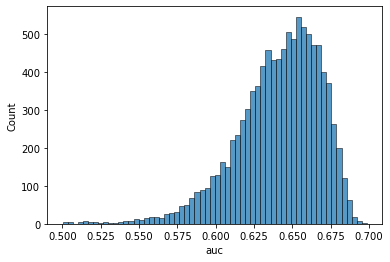

In [259]:
sns.histplot(df_auc_gene_exp[df_auc_gene_exp['avg_rank']>0.7]['auc'])

<AxesSubplot:xlabel='auc', ylabel='Count'>

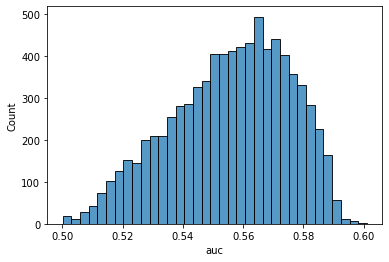

In [253]:
sns.histplot(df_auc_gene_exp[df_auc_gene_exp['avg_rank']>0.8]['auc'])

In [ ]:
    row, col=np.nonzero(arr_thresh)
    c = np.unique(col)
    arr = arr_thresh[:,c] #columns whose sum is zero throughout are removed

    zero_row_indices = np.where(~arr.any(axis=1))[0] #[when the gene row sum is zero, its jaccard similarity is zero]
    
    try:

        jac_sim = 1 - pairwise_distances(arr, metric = "jaccard")  #[calculates the jaccard coefficient for each bin pair based on the , allbins X allbins where values are number of common neighbours]
        jac_sim[zero_row_indices,:] = 0
    
    except ValueError:

        jac_sim = np.zeros((arr_thresh.shape[0], arr_thresh.shape[0]))
    print (jac_sim.shape)

    return jac_sim

In [657]:
arr = np.array([[1, 1], [0, 0]])

In [662]:
a, b = np.nonzero(arr)

In [664]:
np.unique(b)

array([0, 1])

In [661]:
arr

array([[1, 1],
       [0, 0]])

In [659]:
1 - pairwise_distances(arr, metric = "jaccard") 

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


array([[1., 0.],
       [0., 1.]])

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

In [196]:
high_auc_gene = df_auc[df_auc['auc'] > 0]['gene_id_exp_file'].tolist()

In [739]:
high_auc_gene = exp_genes[exp_genes['avg_rank'] > 0.7]['genes'].tolist()

In [223]:
exp_genes

genes  avg_rank
0      ENSG00000223972  0.443509
1      ENSG00000227232  0.733437
2      ENSG00000278267  0.548917
3      ENSG00000243485  0.397697
4      ENSG00000284332  0.301684
...                ...       ...
64480  ENSG00000276017  0.321917
64481  ENSG00000278817  0.649758
64482  ENSG00000277196  0.612010
64483  ENSG00000278625  0.314648
64484  ENSG00000277374  0.302087

[64440 rows x 2 columns]

In [740]:
df_gene_tp_sel = df_gene_tp[df_gene_tp.index.isin(high_auc_gene)]

In [726]:
high_auc_gene = df_auc[df_auc['auc'] > 0.6]['gene_id_exp_file'].tolist()

In [729]:
df_gene_tp_sel = df_gene_tp_sel[df_gene_tp_sel.index.isin(high_auc_gene)]

In [741]:
cre_bins = df_cre_1kb_encode[df_cre_1kb_encode['cre']>14]['bin_id'].tolist()

In [614]:
len(cre_bins)/3000

2.780666666666667

In [743]:
df_cre_1kb_encode

start_bin  cre    chr      start        end  bin_id  \
0           chr10_10000    1  chr10      10000      20000  167493   
1          chr10_100000    1  chr10     100000     110000  167502   
2         chr10_1000000    1  chr10    1000000    1010000  167592   
3        chr10_10000000    6  chr10   10000000   10010000  168492   
4       chr10_100000000   16  chr10  100000000  100010000  177492   
...                 ...  ...    ...        ...        ...     ...   
213396    chr9_99940000    1   chr9   99940000   99950000  163646   
213397    chr9_99950000    1   chr9   99950000   99960000  163647   
213398    chr9_99960000    1   chr9   99960000   99970000  163648   
213399    chr9_99970000    2   chr9   99970000   99980000  163649   
213400    chr9_99990000    1   chr9   99990000  100000000  163651   

                    pos  
0           chr10_10000  
1          chr10_100000  
2         chr10_1000000  
3        chr10_10000000  
4       chr10_100000000  
...                 ...  
213396    chr9_99940000  
213397    chr9_99950000  
213398    chr9_99960000  
213399    chr9_99970000  
213400    chr9_99990000  

[213401 rows x 7 columns]

In [742]:
df_gene_tp_sel = df_gene_tp_sel[cre_bins]

In [732]:
df_2d_jac, go_chrom  = run_egad(df_gene_tp_sel, df_exp_corr)

(13157, 13157)
(13157, 8342)
0.9693905994526353
0.0


<ipython-input-212-46e24587dd68>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


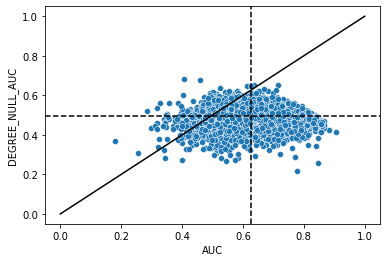

In [759]:
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [763]:
df_2d_jac['AUC'].mean()

0.6265078142907863

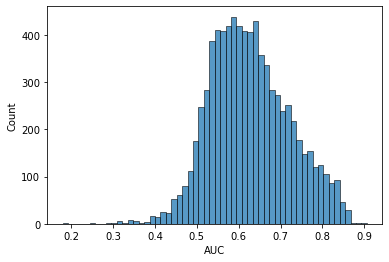

In [760]:
ax = sns.histplot(df_2d_jac['AUC'])


<AxesSubplot:xlabel='DEGREE_NULL_AUC', ylabel='Count'>

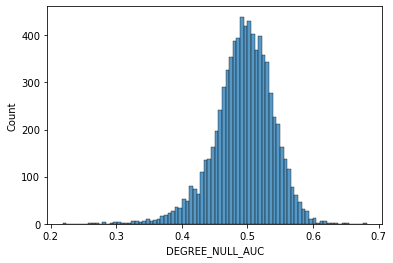

In [646]:
sns.histplot(df_2d_jac['DEGREE_NULL_AUC'])

In [ ]:
    row, col=np.nonzero(arr_thresh)
    c = np.unique(col)
    arr = arr_thresh[:,c] #columns whose sum is zero throughout are removed

    zero_row_indices = np.where(~arr.any(axis=1))[0] #[when the gene row sum is zero, its jaccard similarity is zero]
    
    try:

        jac_sim = 1 - pairwise_distances(arr, metric = "jaccard")  #[calculates the jaccard coefficient for each bin pair based on the , allbins X allbins where values are number of common neighbours]
        jac_sim[zero_row_indices,:] = 0
    
    except ValueError:

        jac_sim = np.zeros((arr_thresh.shape[0], arr_thresh.shape[0]))
    print (jac_sim.shape)

    return jac_sim

In [673]:
arr

array([[1, 1],
       [0, 0]])

In [693]:
arr = df_gene_tp_sel.to_numpy().T

In [692]:
df_gene_tp_sel

177492  177557  177565  177566  177580  177591  177593  \
ENSG00000000419       0       0       0       0       0       0       0   
ENSG00000000457       1       0       0       0       0       0       0   
ENSG00000000460       0       0       0       0       0       0       0   
ENSG00000000938       0       0       0       0       0       1       0   
ENSG00000000971       0       0       0       0       0       0       0   
...                 ...     ...     ...     ...     ...     ...     ...   
ENSG00000285280       0       0       0       0       0       0       0   
ENSG00000285331       0       0       0       0       0       0       0   
ENSG00000285399       0       0       0       0       0       0       0   
ENSG00000285410       0       0       0       0       0       0       0   
ENSG00000285437       0       0       0       0       0       0       1   

                 177598  177605  177614  ...  163203  163254  153749  163437  \
ENSG00000000419       0       0       0  ...       0       0       0       0   
ENSG00000000457       0       0       0  ...       0       0       0       0   
ENSG00000000460       0       0       0  ...       0       0       0       0   
ENSG00000000938       0       0       0  ...       0       0       0       0   
ENSG00000000971       0       0       0  ...       0       0       0       0   
...                 ...     ...     ...  ...     ...     ...     ...     ...   
ENSG00000285280       0       0       0  ...       0       0       0       0   
ENSG00000285331       0       0       0  ...       0       0       0       0   
ENSG00000285399       0       0       0  ...       0       0       0       0   
ENSG00000285410       1       0       0  ...       0       0       0       0   
ENSG00000285437       0       0       0  ...       0       0       0       0   

                 163450  163474  163477  163557  163562  163634  
ENSG00000000419       0       0       0       0       0       0  
ENSG00000000457       0       0       0       0       0       0  
ENSG00000000460       0       0       0       0       0       0  
ENSG00000000938       0       0       0       0       0       0  
ENSG00000000971       0       0       0       0       0       0  
...                 ...     ...     ...     ...     ...     ...  
ENSG00000285280       0       0       0       0       0       0  
ENSG00000285331       0       0       0       0       0       0  
ENSG00000285399       0       0       0       0       0       0  
ENSG00000285410       0       0       0       0       0       0  
ENSG00000285437       0       0       0       0       0       0  

[13158 rows x 8342 columns]

In [694]:
    zero_row_indices = np.where(~arr.any(axis=1))[0] #[when the gene row sum is zero, its jaccard similarity is zero]
    


    jac_sim = 1 - pairwise_distances(arr, metric = "jaccard")  #[calculates the jaccard coefficient for each bin pair based on the , allbins X allbins where values are number of common neighbours]
    jac_sim[zero_row_indices,:] = 0

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [795]:
arr[0:5,0:10]

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [791]:
jac_sim.shape

(8342, 8342)

In [792]:
jac_sim

array([[1.        , 0.01764706, 0.01829268, ..., 0.        , 0.00561798,
        0.00651466],
       [0.01764706, 1.        , 0.04545455, ..., 0.        , 0.        ,
        0.        ],
       [0.01829268, 0.04545455, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.02222222,
        0.01369863],
       [0.00561798, 0.        , 0.        , ..., 0.02222222, 1.        ,
        0.        ],
       [0.00651466, 0.        , 0.        , ..., 0.01369863, 0.        ,
        1.        ]])

In [696]:
jac_sim_tp = pd.DataFrame(jac_sim ,  index=df_gene_tp_sel.columns.tolist(), columns = df_gene_tp_sel.columns.tolist())


In [697]:
per_bin_similarity = np.median(jac_sim, axis=0)

<AxesSubplot:ylabel='Count'>

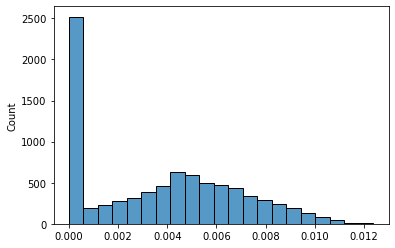

In [698]:
sns.histplot(per_bin_similarity)

In [683]:
jac_sim

array([[1.        , 0.01766004, 0.00737101, ..., 0.02401747, 0.06763285,
        0.06045752],
       [0.01766004, 1.        , 0.05369128, ..., 0.00465116, 0.04591837,
        0.01020408],
       [0.00737101, 0.05369128, 1.        , ..., 0.01851852, 0.02571429,
        0.00290698],
       ...,
       [0.02401747, 0.00465116, 0.01851852, ..., 1.        , 0.039801  ,
        0.01253133],
       [0.06763285, 0.04591837, 0.02571429, ..., 0.039801  , 1.        ,
        0.02572899],
       [0.06045752, 0.01020408, 0.00290698, ..., 0.01253133, 0.02572899,
        1.        ]])

In [724]:
import matplotlib.pyplot as plt
sns.scatterplot(df_t['AUC'], df_t['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_t['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_t['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

KeyError: 'AUC'

In [577]:
df_t['AUC'].mean()

0.6627436316077938

In [450]:
sns.regplot(y=df_gene_tp_sel.sum(), x=df_2d_jac['AUC'])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 317 and the array at index 1 has size 353

In [782]:
df_t = df_2d_jac.merge(df_gene_tp_sel.sum().reset_index(), left_on=df_2d_jac.index, right_on='index')

In [780]:
df_t = jac_sim_tp.mean().reset_index().merge(df_gene_tp_sel.mean().reset_index(), left_on='index', right_on='index')



In [745]:
df_t = df_2d_jac.merge(df_cre_1kb_encode, left_on=df_2d_jac.index, right_on='bin_id')

start_bin  cre    chr      start        end  bin_id  \
0           chr10_10000    1  chr10      10000      20000  167493   
1          chr10_100000    1  chr10     100000     110000  167502   
2         chr10_1000000    1  chr10    1000000    1010000  167592   
3        chr10_10000000    6  chr10   10000000   10010000  168492   
4       chr10_100000000   16  chr10  100000000  100010000  177492   
...                 ...  ...    ...        ...        ...     ...   
213396    chr9_99940000    1   chr9   99940000   99950000  163646   
213397    chr9_99950000    1   chr9   99950000   99960000  163647   
213398    chr9_99960000    1   chr9   99960000   99970000  163648   
213399    chr9_99970000    2   chr9   99970000   99980000  163649   
213400    chr9_99990000    1   chr9   99990000  100000000  163651   

                    pos  
0           chr10_10000  
1          chr10_100000  
2         chr10_1000000  
3        chr10_10000000  
4       chr10_100000000  
...                 ...  
213396    chr9_99940000  
213397    chr9_99950000  
213398    chr9_99960000  
213399    chr9_99970000  
213400    chr9_99990000  

[213401 rows x 7 columns]

In [784]:
df_t = df_2d_jac.merge(jac_sim_tp.mean().reset_index(), left_on=df_2d_jac.index, right_on='index')

In [783]:
df_t

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value   index    0
0     0.548648     10432.251330         0.500019  2.071635e-02  177492  147
1     0.593454     10135.578246         0.442564  5.234711e-02  177557   26
2     0.536454     10060.668246         0.407840  2.975338e-01  177565   20
3     0.624543     10300.179106         0.478141  5.764654e-07  177566  127
4     0.461897     10385.444057         0.516128  6.432477e-02  177580  129
...        ...              ...              ...           ...     ...  ...
7876  0.601389     10454.027772         0.510980  1.831122e-08  163474  249
7877  0.560149     10544.321932         0.529888  4.074555e-03  163477  159
7878  0.525629     10027.908366         0.415976  2.571734e-01  163557   60
7879  0.660111     10531.933967         0.498688  3.683678e-03  163562   32
7880  0.692969     10628.637247         0.547172  1.431164e-17  163634  162

[7881 rows x 6 columns]

In [785]:
df_t

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value   index  \
0     0.548648     10432.251330         0.500019  2.071635e-02  177492   
1     0.593454     10135.578246         0.442564  5.234711e-02  177557   
2     0.536454     10060.668246         0.407840  2.975338e-01  177565   
3     0.624543     10300.179106         0.478141  5.764654e-07  177566   
4     0.461897     10385.444057         0.516128  6.432477e-02  177580   
...        ...              ...              ...           ...     ...   
7876  0.601389     10454.027772         0.510980  1.831122e-08  163474   
7877  0.560149     10544.321932         0.529888  4.074555e-03  163477   
7878  0.525629     10027.908366         0.415976  2.571734e-01  163557   
7879  0.660111     10531.933967         0.498688  3.683678e-03  163562   
7880  0.692969     10628.637247         0.547172  1.431164e-17  163634   

             0  
0     0.006726  
1     0.001718  
2     0.001666  
3     0.006697  
4     0.006302  
...        ...  
7876  0.007217  
7877  0.006246  
7878  0.003324  
7879  0.001810  
7880  0.006360  

[7881 rows x 6 columns]

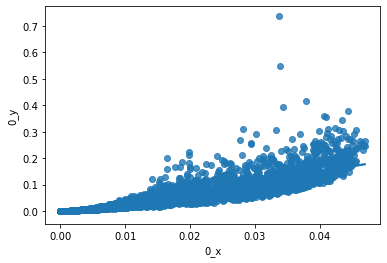

In [723]:
ax = sns.regplot(x=df_t['0_x'], y=df_t['0_y'])

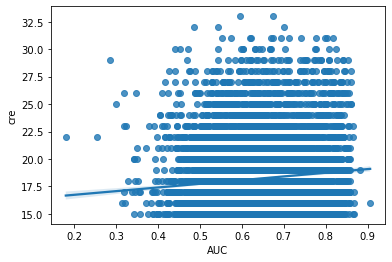

In [746]:
ax = sns.regplot(x=df_t['AUC'], y=df_t['cre'])

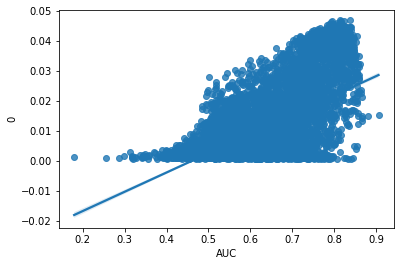

In [720]:
ax = sns.regplot(x=df_t['AUC'], y=df_t[0])
#ax.set_ylim([200,4000])

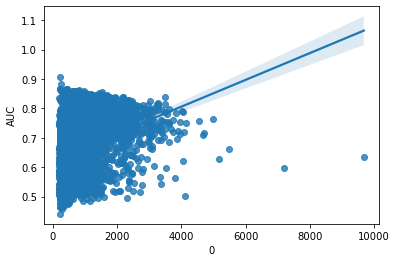

In [596]:
ax = sns.regplot(y=df_t['AUC'], x=df_t[0])
#ax.set_ylim([200,4000])

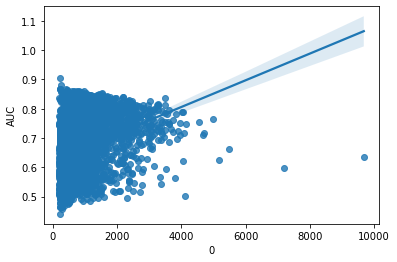

In [606]:
ax = sns.regplot(y=df_t['AUC'], x=df_t[0])
#ax.set_ylim([200,4000])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(200.0, 4000.0)

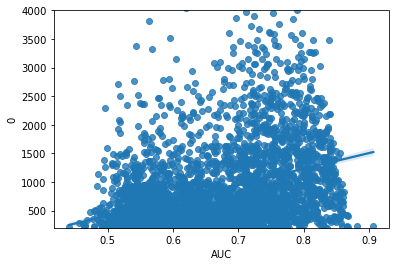

In [607]:
ax = sns.regplot(df_t['AUC'], df_t[0])
ax.set_ylim([200,4000])

In [633]:
df_t = df_t[df_t[0] > 200]

In [559]:
df_t[df_t[0] > 200]['AUC'].mean()

0.712922990580443

In [786]:
df_t['quintile'] = pd.qcut(df_t[0] , 10, labels=np.arange(10, 0, -1))

In [781]:
df_t

index       0_x       0_y
0     177492  0.006726  0.011172
1     177557  0.001718  0.001976
2     177565  0.001666  0.001520
3     177566  0.006697  0.009652
4     177580  0.006302  0.009804
...      ...       ...       ...
8337  163474  0.007217  0.018924
8338  163477  0.006246  0.012084
8339  163557  0.003324  0.004560
8340  163562  0.001810  0.002432
8341  163634  0.006360  0.012312

[8342 rows x 3 columns]

In [ ]:
df_t3 = df[]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cre', ylabel='AUC'>

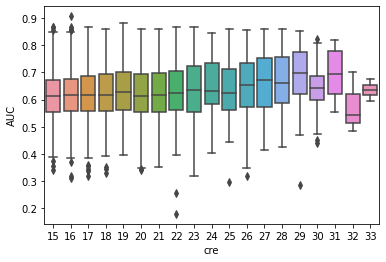

In [750]:
sns.boxplot(df_t['cre'], df_t['AUC'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quintile', ylabel='AUC'>

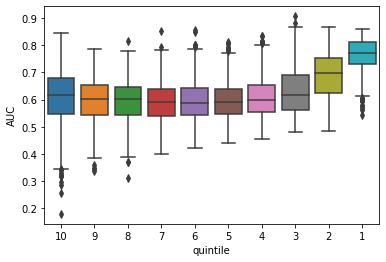

In [787]:
sns.boxplot(df_t['quintile'], df_t['AUC'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quintile', ylabel='0'>

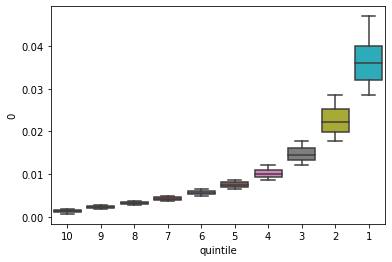

In [788]:
sns.boxplot(df_t['quintile'], df_t[0])

In [790]:
kl

NameError: name 'kl' is not defined

In [637]:
df_t

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value   index     0  \
5     0.616393     10677.110581         0.574954  2.229388e-68  177591  1983   
6     0.643438     10423.044345         0.506708  6.842470e-15  177593   243   
7     0.661095     10549.253120         0.537769  6.572295e-78  177598  1153   
10    0.592403     10726.062502         0.583689  3.225288e-27  177673  1163   
11    0.628581     10568.321206         0.543337  1.806364e-30  177675   669   
...        ...              ...              ...           ...     ...   ...   
7847  0.574790     10368.410197         0.494411  1.346064e-08  162958   466   
7848  0.610147     10344.599261         0.476780  1.047082e-13  162961   370   
7859  0.590189     10476.625638         0.515784  3.574001e-08  163139   302   
7869  0.653807     10353.187277         0.491195  2.825903e-18  163201   264   
7876  0.601389     10454.027772         0.510980  1.831122e-08  163474   249   

     quintile  
5           1  
6           5  
7           2  
10          2  
11          3  
...       ...  
7847        3  
7848        4  
7859        4  
7869        5  
7876        5  

[3517 rows x 7 columns]

<AxesSubplot:xlabel='0', ylabel='Count'>

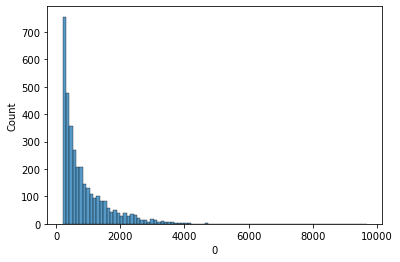

In [639]:
sns.histplot(df_t[0])

In [ ]:
    row, col=np.nonzero(arr_thresh)
    c = np.unique(col)
    arr = arr_thresh[:,c] #columns whose sum is zero throughout are removed

    zero_row_indices = np.where(~arr.any(axis=1))[0] #[when the gene row sum is zero, its jaccard similarity is zero]
    
    try:

        jac_sim = 1 - pairwise_distances(arr, metric = "jaccard")  #[calculates the jaccard coefficient for each bin pair based on the , allbins X allbins where values are number of common neighbours]
        jac_sim[zero_row_indices,:] = 0
    
    except ValueError:

        jac_sim = np.zeros((arr_thresh.shape[0], arr_thresh.shape[0]))
    print (jac_sim.shape)

    return jac_sim

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quintile', ylabel='AUC'>

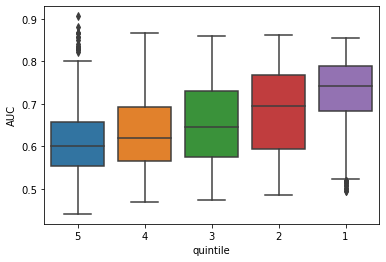

In [636]:
sns.boxplot(df_t['quintile'], df_t['AUC'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quintile', ylabel='0'>

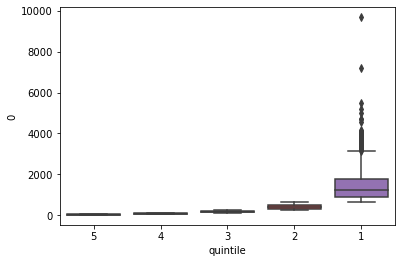

In [624]:
sns.boxplot(df_t['quintile'], df_t[0])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quintile', ylabel='AUC'>

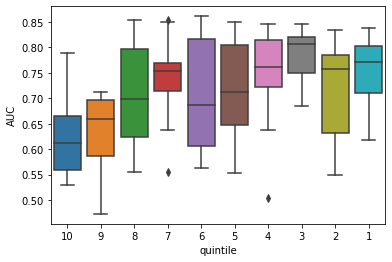

In [497]:
sns.boxplot(df_t['quintile'], df_t['AUC'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quintile', ylabel='0'>

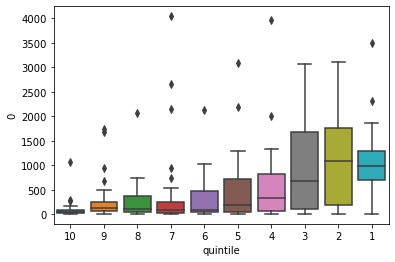

In [506]:
sns.boxplot(df_t['quintile'], df_t[0])

<AxesSubplot:xlabel='0', ylabel='Count'>

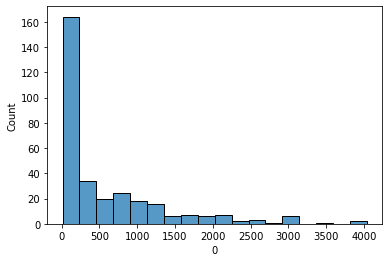

In [483]:
sns.histplot(df_t[0])

In [458]:
df_gene_tp_sel.sum().reset_index()

index     0
0    177756   291
1    177925   243
2    179205     8
3    179246    41
4    180007    46
..      ...   ...
348  167382   366
349  167383  1249
350  167397  1197
351  155083    95
352  157355    70

[353 rows x 2 columns]

In [459]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC        P_Value
177756  0.694618     10500.181796         0.509848   1.026297e-30
177925  0.631797     10535.329907         0.520753   6.526691e-13
179246  0.519682     10509.999055         0.516117   3.201657e-01
180007  0.472075     10166.996643         0.449793   9.773137e-02
180732  0.705574     10649.275532         0.552092   2.526553e-11
...          ...              ...              ...            ...
167382  0.854699     10305.766939         0.456235  1.929063e-121
167383  0.815536     10385.243341         0.480409   0.000000e+00
167397  0.834100     10380.869757         0.475889   0.000000e+00
155083  0.609623     10369.637178         0.486403   9.945919e-05
157355  0.522972     10258.660888         0.457565   2.325480e-01

[317 rows x 4 columns]

In [454]:
df_2d_jac['AUC']

177756    0.694618
177925    0.631797
179246    0.519682
180007    0.472075
180732    0.705574
            ...   
167382    0.854699
167383    0.815536
167397    0.834100
155083    0.609623
157355    0.522972
Name: AUC, Length: 317, dtype: float64

In [447]:
df_gene_tp_sel.sum()

177756     291
177925     243
179205       8
179246      41
180007      46
          ... 
167382     366
167383    1249
167397    1197
155083      95
157355      70
Length: 353, dtype: int64

In [337]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC        P_Value
177756  0.694618     10500.181796         0.509848   1.026297e-30
177925  0.631797     10535.329907         0.520753   6.526691e-13
179246  0.519682     10509.999055         0.516117   3.201657e-01
180007  0.472075     10166.996643         0.449793   9.773137e-02
180732  0.705574     10649.275532         0.552092   2.526553e-11
...          ...              ...              ...            ...
167382  0.854699     10305.766939         0.456235  1.929063e-121
167383  0.815536     10385.243341         0.480409   0.000000e+00
167397  0.834100     10380.869757         0.475889   0.000000e+00
155083  0.609623     10369.637178         0.486403   9.945919e-05
157355  0.522972     10258.660888         0.457565   2.325480e-01

[317 rows x 4 columns]

<AxesSubplot:xlabel='AUC', ylabel='Count'>

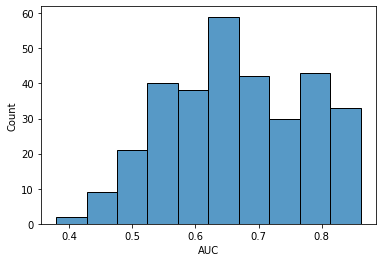

In [442]:
sns.histplot(df_2d_jac['AUC'])

<AxesSubplot:xlabel='AUC', ylabel='Count'>

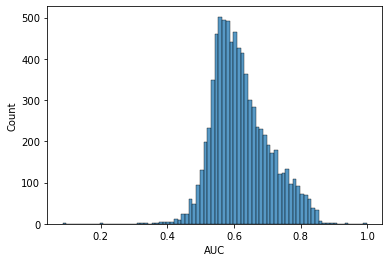

In [203]:
sns.histplot(df_2d_jac['AUC'])

<AxesSubplot:xlabel='AUC', ylabel='Count'>

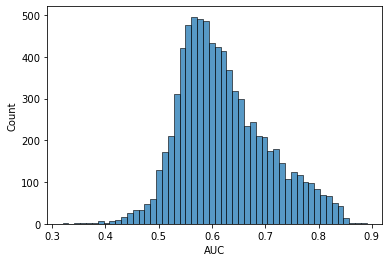

In [216]:
sns.histplot(df_2d_jac['AUC'])

In [ ]:
df.iloc[ind_list]

In [27]:
%matplotlib inline
import seaborn as sns

<AxesSubplot:xlabel='avg_rank_d', ylabel='auc'>

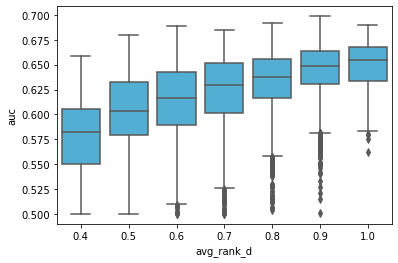

In [260]:
df_auc_gene_exp['avg_rank_d'] = df_auc_gene_exp['avg_rank'].round(1)
sns.boxplot(data=df_auc_gene_exp[df_auc_gene_exp['genes'].isin(df_exp_corr.index.tolist())], x='avg_rank_d', y='auc', palette=['#3CB7E8'])



In [210]:
df_auc_gene_exp

genes  avg_rank gene_id_exp_file       auc     cat  \
0      ENSG00000223972  0.443509  ENSG00000223972  0.593487     non   
1      ENSG00000227232  0.733437  ENSG00000227232  0.599505     non   
2      ENSG00000278267  0.548917  ENSG00000278267  0.593487     non   
3      ENSG00000243485  0.397697  ENSG00000243485  0.557661     non   
4      ENSG00000284332  0.301684  ENSG00000284332  0.547544     non   
...                ...       ...              ...       ...     ...   
55406  ENSG00000100312  0.311248  ENSG00000100312  0.551436     non   
55407  ENSG00000254499  0.308634  ENSG00000254499  0.535070     non   
55408  ENSG00000213683  0.303345  ENSG00000213683  0.499738     non   
55409  ENSG00000184319  0.811295  ENSG00000184319  0.720974     non   
55410  ENSG00000079974  0.854376  ENSG00000079974  0.717120  marker   

       avg_rank_d  
0             0.4  
1             0.7  
2             0.5  
3             0.4  
4             0.3  
...           ...  
55406         0.3  
55407         0.3  
55408         0.3  
55409         0.8  
55410         0.9  

[55411 rows x 6 columns]

<AxesSubplot:xlabel='auc', ylabel='Count'>

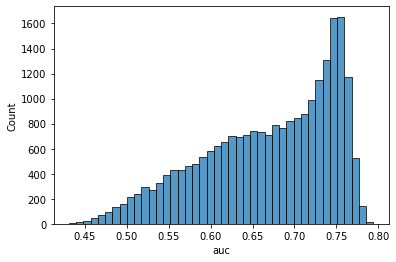

In [207]:
sns.histplot(df_auc_gene_exp[df_auc_gene_exp['genes'].isin(df_exp_corr.index.tolist())]['auc'])

<AxesSubplot:xlabel='auc', ylabel='Count'>

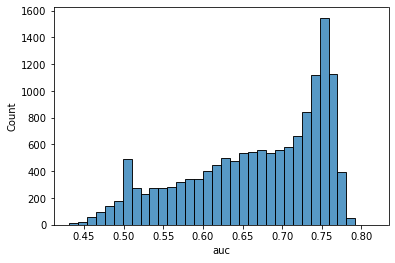

In [211]:
sns.histplot(df_auc_gene_exp[df_auc_gene_exp['cat'].isin(['marker'])]['auc'])

<AxesSubplot:xlabel='auc', ylabel='Count'>

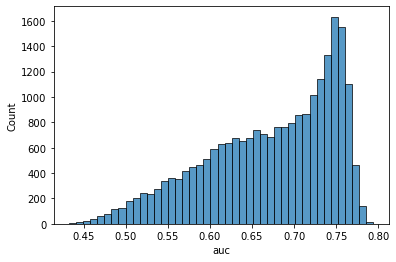

In [209]:
sns.histplot(df_auc_gene_exp[df_auc_gene_exp['avg_rank']>0.5]['auc'])

In [205]:
df_auc_gene_exp

genes  avg_rank gene_id_exp_file       auc     cat  \
0      ENSG00000223972  0.443509  ENSG00000223972  0.593487     non   
1      ENSG00000227232  0.733437  ENSG00000227232  0.599505     non   
2      ENSG00000278267  0.548917  ENSG00000278267  0.593487     non   
3      ENSG00000243485  0.397697  ENSG00000243485  0.557661     non   
4      ENSG00000284332  0.301684  ENSG00000284332  0.547544     non   
...                ...       ...              ...       ...     ...   
55406  ENSG00000100312  0.311248  ENSG00000100312  0.551436     non   
55407  ENSG00000254499  0.308634  ENSG00000254499  0.535070     non   
55408  ENSG00000213683  0.303345  ENSG00000213683  0.499738     non   
55409  ENSG00000184319  0.811295  ENSG00000184319  0.720974     non   
55410  ENSG00000079974  0.854376  ENSG00000079974  0.717120  marker   

       avg_rank_d  
0             0.4  
1             0.7  
2             0.5  
3             0.4  
4             0.3  
...           ...  
55406         0.3  
55407         0.3  
55408         0.3  
55409         0.8  
55410         0.9  

[55411 rows x 6 columns]

In [85]:
df_auc_gene_exp['cat'] = ['marker' if x in marker_list['Ensembl_gene_identifier'].tolist() else 'non' for x in df_auc_gene_exp['gene_id_exp_file'].tolist()]



In [82]:
df_auc_gene_exp

genes  avg_rank gene_id_exp_file       auc     cat
0      ENSG00000223972  0.443509  ENSG00000223972  0.593487     non
1      ENSG00000227232  0.733437  ENSG00000227232  0.599505     non
2      ENSG00000278267  0.548917  ENSG00000278267  0.593487     non
3      ENSG00000243485  0.397697  ENSG00000243485  0.557661     non
4      ENSG00000284332  0.301684  ENSG00000284332  0.547544     non
...                ...       ...              ...       ...     ...
55406  ENSG00000100312  0.311248  ENSG00000100312  0.551436     non
55407  ENSG00000254499  0.308634  ENSG00000254499  0.535070     non
55408  ENSG00000213683  0.303345  ENSG00000213683  0.499738     non
55409  ENSG00000184319  0.811295  ENSG00000184319  0.720974     non
55410  ENSG00000079974  0.854376  ENSG00000079974  0.717120  marker

[55411 rows x 5 columns]

<AxesSubplot:xlabel='cat', ylabel='avg_rank'>

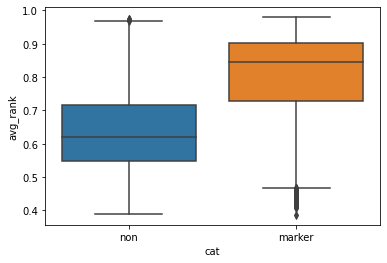

In [86]:
sns.boxplot(data=df_auc_gene_exp[df_auc_gene_exp['genes'].isin(df_exp_corr.index.tolist())], y='avg_rank', x='cat')

<AxesSubplot:xlabel='cat', ylabel='auc'>

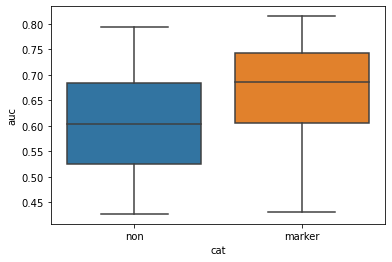

In [91]:
sns.boxplot(data=df_auc_gene_exp, y='auc', x='cat')

In [84]:
all_markers_df = []
for marker_type in ['class', 'subclass', 'type']:
	marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/{species}/{marker_type}_markers_top1000.csv.gz', skiprows=1)
	all_markers_df.append(marker_list)

marker_list = pd.concat(all_markers_df)
marker_list = marker_list.drop_duplicates(subset=['gene'])
df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
marker_list = marker_list.merge(df_ensg_name.drop_duplicates(subset=['Symbol']), right_on='Symbol', left_on='gene') 
marker_list = marker_list.drop_duplicates(subset=['Ensembl_gene_identifier'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [71]:
marker_list

group cell_type  rank       gene  recurrence     auroc  fold_change  \
0      Astro   Astro_1     1  DPP10-AS3           3  0.797253     3.094005   
1      Astro   Astro_1     2      DPP10           2  0.893438     3.436569   
2      Astro   Astro_1     3        ID2           1  0.792967     2.405181   
3      Astro   Astro_1     4       JUNB           1  0.723300     1.565228   
4      Astro   Astro_1     5       GPC6           1  0.693258     1.279651   
...      ...       ...   ...        ...         ...       ...          ...   
14434   VLMC    VLMC_2   895      DHCR7           0  0.600624     4.999688   
14435   VLMC    VLMC_2   909        PGF           0  0.599718     3.393679   
14436   VLMC    VLMC_2   910       VAT1           0  0.599639     3.673718   
14437   VLMC    VLMC_2   920     DCAF15           0  0.599207     1.939877   
14438   VLMC    VLMC_2   996     RUVBL2           0  0.596416     3.699655   

       fold_change_detection   expression  precision  ...  H200.1025_SSv4  \
0                   1.818261     0.000000   0.092445  ...           False   
1                   1.204534  4519.887362   0.026629  ...           False   
2                   1.507432   157.828504   0.033903  ...           False   
3                   1.783512     0.000000   0.074596  ...           False   
4                   2.200657    27.131271   0.053557  ...           False   
...                      ...          ...        ...  ...             ...   
14434              13.836867     0.000000        NaN  ...             NaN   
14435               6.606525     0.000000        NaN  ...             NaN   
14436               7.085874     0.000000        NaN  ...             NaN   
14437               4.796181     0.000000        NaN  ...             NaN   
14438               7.986018     0.000000        NaN  ...             NaN   

       H200.1023_SSv4  H18.30.002_10Xv3 H200.1023_10Xv3 H18.30.001_10Xv3  \
0                 NaN              True             NaN              NaN   
1                 NaN              True             NaN              NaN   
2                 NaN             False             NaN              NaN   
3                 NaN             False             NaN              NaN   
4                 NaN             False             NaN              NaN   
...               ...               ...             ...              ...   
14434           False             False             NaN            False   
14435           False             False             NaN            False   
14436           False             False             NaN            False   
14437           False             False             NaN            False   
14438           False             False             NaN            False   

      H19.30.001_10Xv3  H19.30.001_NextGEM H19.30.002_10Xv3  \
0                False                True             True   
1                False                True            False   
2                False               False             True   
3                False               False             True   
4                False                True            False   
...                ...                 ...              ...   
14434            False               False            False   
14435            False               False            False   
14436            False               False            False   
14437            False               False            False   
14438            False               False            False   

      Ensembl_gene_identifier     Symbol  
0             ENSG00000231538  DPP10-AS3  
1             ENSG00000175497      DPP10  
2             ENSG00000115738        ID2  
3             ENSG00000171223       JUNB  
4             ENSG00000183098       GPC6  
...                       ...        ...  
14434         ENSG00000172893      DHCR7  
14435         ENSG00000119630        PGF  
14436         ENSG00000108828       VAT1  
14437         ENSG00000132017     DCAF15  
14

In [64]:
marker_list_exp = marker_list.merge(exp_genes, left_on='Ensembl_gene_identifier', right_on='genes')

<AxesSubplot:xlabel='rank_d', ylabel='avg_rank'>

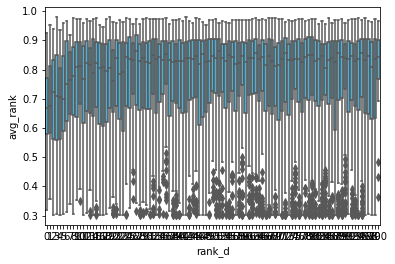

In [72]:
marker_list_exp['rank_d'] = marker_list_exp['rank']/10
marker_list_exp['rank_d'] = marker_list_exp['rank_d'].astype('int')
sns.boxplot(data=marker_list_exp, y='avg_rank', x='rank_d', palette=['#3CB7E8'])